# Convex Minimization Many Examples

This notebook presents many examples for the convex minimization problem.

In [30]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [31]:
# Setup
ACT_DIM = 2 # action space dimensions
ETA = 1e-8 # used to enforce strict inequality

alpha = cp.Parameter() # (> 1) constraint on maximum policy ratio

# safe policy (cvxpy parameters)
mu_safe = cp.Parameter(ACT_DIM)
sigma_safe = cp.Parameter(ACT_DIM, pos=True)

# task policy (cvxpy parameters)
mu_task = cp.Parameter(ACT_DIM)
sigma_task = cp.Parameter(ACT_DIM, pos=True)

# projected policy (cvxpy variables)
mu_proj = cp.Variable(ACT_DIM)
sigma_proj = cp.Variable(ACT_DIM, pos=True)


# Additional variables/parameters for DPP
# safe policy (cvxpy parameters)
sigma_safe_inv = cp.Parameter(ACT_DIM, pos=True) # 1/sigma_safe
sigma_sigma_safe = cp.Parameter(ACT_DIM, pos=True) # sigma_safe^2

# task policy (cvxpy parameters)
sigma_task_inv = cp.Parameter(ACT_DIM, pos=True) # 1/sigma_task
mu_sigma_task = cp.Parameter(ACT_DIM) # mu_task/sigma_task
mu_sigma_sigma_task = cp.Parameter(ACT_DIM)   # mu_task/(sigma_task)^2

# sum term (cvxpy variables)
mu_safe_var = cp.Variable(ACT_DIM)   # mu_safe
sigma_sigma_safe_var = cp.Variable(ACT_DIM, pos=True)   # sigma_safe^2

In [32]:
# Problem re-definition as DPP
objective_dpp = cp.Minimize(-2*cp.sum(cp.log(sigma_proj)) +  cp.sum_squares(cp.multiply(sigma_proj,sigma_task_inv)) + cp.sum_squares(cp.multiply(mu_proj,sigma_task_inv)) - 2*cp.sum(cp.multiply(mu_proj, mu_sigma_sigma_task)) + cp.sum_squares(mu_sigma_task))

constraints_dpp = []

constraint_1_dpp = sigma_proj + ETA <= sigma_safe
constraints_dpp.append(constraint_1_dpp)

sum_term_dpp = 0    # we define the sum term like this so that we can use quad_over_lin and thus allow the problem to be DCP (standard quotient operator is not DCP)
for i in range(0, ACT_DIM):
    sum_term_dpp += cp.quad_over_lin(mu_proj[i] - mu_safe_var[i],sigma_sigma_safe_var[i] - cp.square(sigma_proj[i]))   # note that numerator gets squared (which we want)

constraint_2_dpp = -cp.sum(cp.log(sigma_safe_inv)) - cp.sum(cp.log(sigma_proj)) + (1/2)*sum_term_dpp <= cp.log(alpha)
constraints_dpp.append(constraint_2_dpp)

constraint_3_dpp = mu_safe_var == mu_safe
constraints_dpp.append(constraint_3_dpp)

constraint_4_dpp = sigma_sigma_safe_var == sigma_sigma_safe
constraints_dpp.append(constraint_4_dpp)

prob_dpp = cp.Problem(objective_dpp, constraints_dpp)

In [36]:
# Generate examples
alpha.value = 1.1 # (> 1) constraint on maximum policy ratio

STRAY_FACTOR = 0.05 # factor on how far the task policy strays from the safe policy

N = 10 # no. examples

mu_safe_list = []
sigma_safe_list = []

mu_task_list = []
sigma_task_list = []

sigma_safe_inv_list = []
sigma_sigma_safe_list = []

sigma_task_inv_list = []
mu_sigma_task_list = []
mu_sigma_sigma_task_list = []

for i in range(0,N):
    # safe policy
    mu_safe_list.append(np.random.randn(ACT_DIM))
    sigma_safe_list.append(np.random.rayleigh(scale=0.5,size=ACT_DIM)) # > 0

    # task policy
    mu_task_list.append(mu_safe_list[i] + STRAY_FACTOR*np.random.randn(ACT_DIM)) # put task policy mean somewhere fairly close to safe policy mean
    sigma_task_list.append(sigma_safe_list[i] - np.minimum(STRAY_FACTOR*sigma_safe_list[i]*np.random.rayleigh(scale=0.5,size=ACT_DIM),sigma_safe_list[i]-ETA))  # put task policy stdev somewhere fairly close to but less than safe policy stdev (and > 0)

    # Set additional DPP parameters for examples

    sigma_safe_inv_list.append(1/sigma_safe_list[i]) # 1/sigma_safe
    sigma_sigma_safe_list.append(np.square(sigma_safe_list[i])) # sigma_safe^2

    # task policy (cvxpy parameters)
    sigma_task_inv_list.append(1/sigma_task_list[i]) # 1/sigma_task
    mu_sigma_task_list.append(mu_task_list[i]/sigma_task_list[i]) # mu_task/sigma_task
    mu_sigma_sigma_task_list.append(mu_task_list[i]/np.square(sigma_task_list[i]))   # mu_task/(sigma_task)^2

In [37]:
mu_proj_list = []
sigma_proj_list = []

for i in range(0,N):
    mu_safe.value = mu_safe_list[i]
    sigma_safe.value = sigma_safe_list[i]

    mu_task.value = mu_task_list[i]
    sigma_task.value = sigma_task_list[i]

    sigma_safe_inv.value = sigma_safe_inv_list[i]
    sigma_sigma_safe.value = sigma_sigma_safe_list[i]

    sigma_task_inv.value = sigma_task_inv_list[i]
    mu_sigma_task.value = mu_sigma_task_list[i]
    mu_sigma_sigma_task.value = mu_sigma_sigma_task_list[i]

    result = prob_dpp.solve()

    mu_proj_list.append(mu_proj.value)
    sigma_proj_list.append(sigma_proj.value)

/tmp/ipykernel_62331/2884111845.py:68: RuntimeWarning: overflow encountered in exp
  policy_ratio[j][i] = np.prod(np.multiply(sigma_safe_list[k]/sigma,np.exp(1/2*np.square(mu_proj_list[k] - mu_safe_list[k])/(np.square(sigma_safe_list[k]) - np.square(sigma)))))


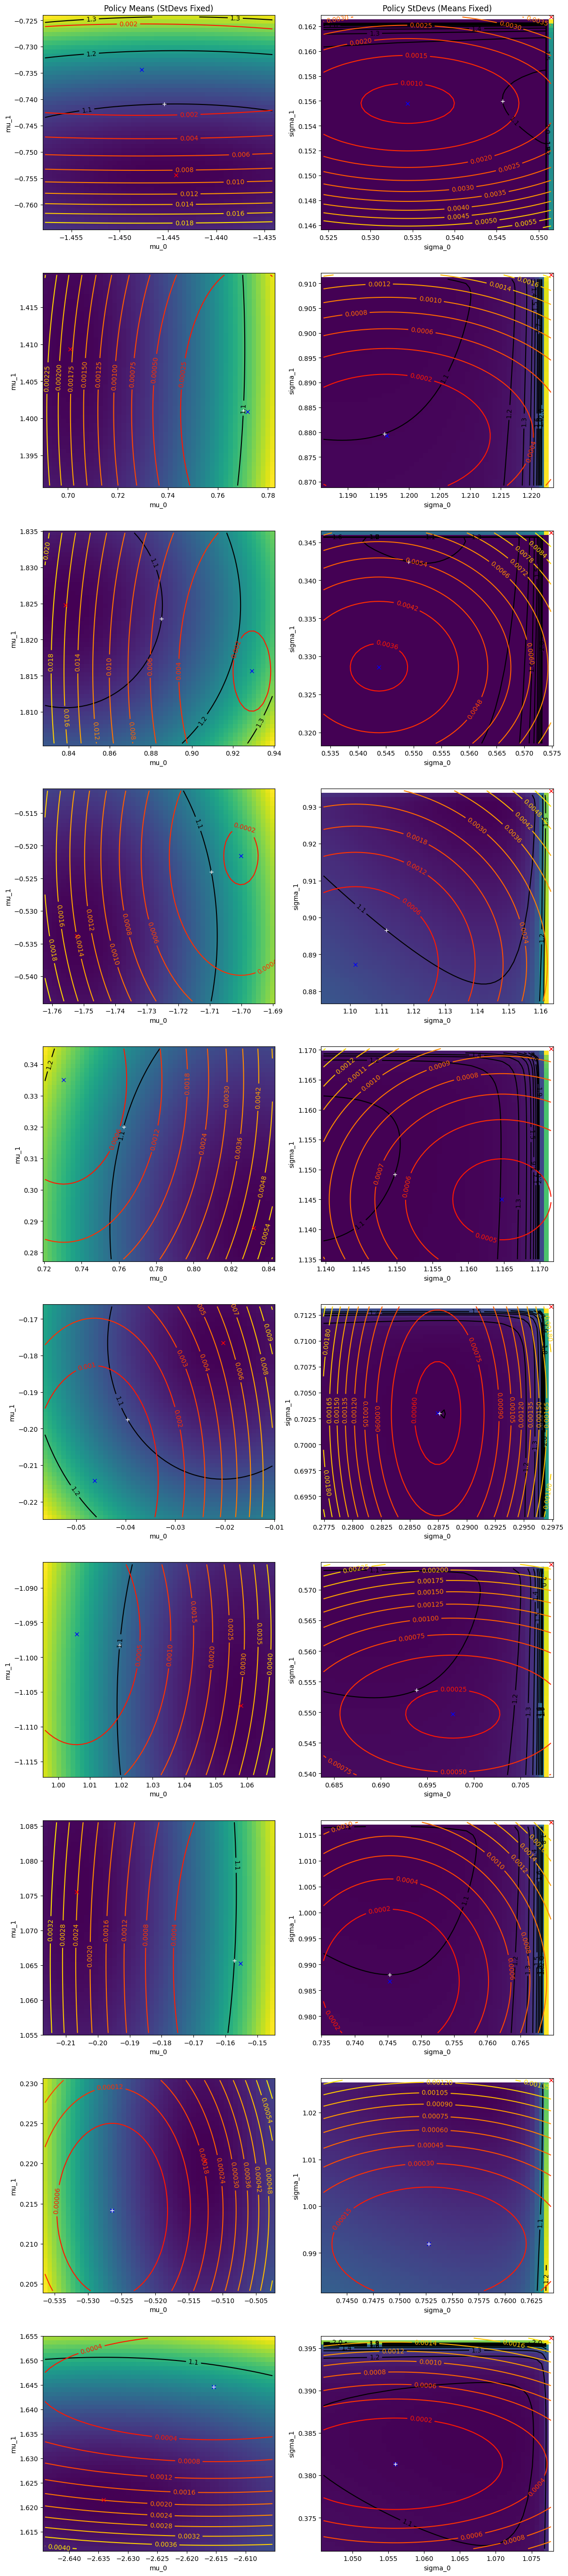

In [42]:
Nx = 50
Ny = 50
N=10
fig, axs = plt.subplots(N,2, figsize=(14, 7*N))

data = np.arange(250, 260)

axs = axs.ravel()

for k in range(0,N):

    mu_x_min = min(mu_safe_list[k][0],mu_task_list[k][0],mu_proj_list[k][0]) - 0.01
    mu_x_max = max(mu_safe_list[k][0],mu_task_list[k][0],mu_proj_list[k][0]) + 0.01

    mu_y_min = min(mu_safe_list[k][1],mu_task_list[k][1],mu_proj_list[k][1]) - 0.01
    mu_y_max = max(mu_safe_list[k][1],mu_task_list[k][1],mu_proj_list[k][1]) + 0.01

    mu_x = np.linspace(mu_x_min,mu_x_max,Nx)
    mu_y = np.linspace(mu_y_min,mu_y_max,Ny)

    policy_ratio = np.zeros((Ny,Nx))
    kl_divergence = np.zeros((Ny,Nx))
    mu = np.zeros(2)

    for i in range(0,Nx):
        for j in range(0,Ny):
            mu[0] = mu_x[i]
            mu[1] = mu_y[j]
            policy_ratio[j][i] = np.prod(np.multiply(sigma_safe_list[k]/sigma_proj_list[k],np.exp(1/2*np.square(mu - mu_safe_list[k])/(np.square(sigma_safe_list[k]) - np.square(sigma_proj_list[k])))))
            kl_divergence[j][i] = 1/2*np.sum(2*np.log(sigma_task_list[k]) - 2*np.log(sigma_proj_list[k]) - 1 + np.square(sigma_proj_list[k])/np.square(sigma_task_list[k]) + np.square(mu - mu_task_list[k])/np.square(sigma_task_list[k]))

    im = axs[2*k].pcolormesh(mu_x,mu_y,policy_ratio)
    # fig.colorbar(im, label="Policy Ratio")
    cs = axs[2*k].contour(mu_x,mu_y,policy_ratio, levels=[1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0], colors='k')
    axs[2*k].clabel(cs, inline=True, fontsize=10)
    kl = axs[2*k].contour(mu_x,mu_y,kl_divergence, levels=10, cmap=cm.autumn)
    axs[2*k].clabel(kl, inline=True, fontsize=10)
    # fig.colorbar(kl, label="KL Divergence", orientation="horizontal")
    axs[2*k].plot(mu_safe_list[k][0],mu_safe_list[k][1],'rx',label="mu_safe")
    axs[2*k].plot(mu_task_list[k][0],mu_task_list[k][1],'bx',label="mu_task")
    axs[2*k].plot(mu_proj_list[k][0],mu_proj_list[k][1],'w+',label="mu_proj")
    axs[2*k].set_xlabel("mu_0")
    axs[2*k].set_ylabel("mu_1")
    
    if k == 0:
        # fig.legend()
        axs[2*k].set_title("Policy Means (StDevs Fixed)")

for k in range(0,N):

    sigma_x_min = max(min(sigma_safe_list[k][0],sigma_task_list[k][0],sigma_proj_list[k][0]) - 0.01,ETA)
    sigma_x_max = sigma_safe_list[k][0] - ETA

    sigma_y_min = max(min(sigma_safe_list[k][1],sigma_task_list[k][1],sigma_proj_list[k][1]) - 0.01,ETA)
    sigma_y_max = sigma_safe_list[k][1] - ETA

    sigma_x = np.linspace(sigma_x_min,sigma_x_max,Nx)
    sigma_y = np.linspace(sigma_y_min,sigma_y_max,Ny)

    policy_ratio = np.zeros((Ny,Nx))
    kl_divergence = np.zeros((Ny,Nx))
    sigma = np.zeros(2)

    for i in range(0,Nx):
        for j in range(0,Ny):
            sigma[0] = sigma_x[i]
            sigma[1] = sigma_y[j]
            policy_ratio[j][i] = np.prod(np.multiply(sigma_safe_list[k]/sigma,np.exp(1/2*np.square(mu_proj_list[k] - mu_safe_list[k])/(np.square(sigma_safe_list[k]) - np.square(sigma)))))
            kl_divergence[j][i] = 1/2*np.sum(2*np.log(sigma_task_list[k]) - 2*np.log(sigma) - 1 + np.square(sigma)/np.square(sigma_task_list[k]) + np.square(mu_proj_list[k] - mu_task_list[k])/np.square(sigma_task_list[k]))

    im = axs[2*k+1].pcolormesh(sigma_x,sigma_y,policy_ratio)
    # fig.colorbar(im, label="Policy Ratio")
    cs = axs[2*k+1].contour(sigma_x,sigma_y,policy_ratio, levels=[1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0], colors='k')
    axs[2*k+1].clabel(cs, inline=True, fontsize=10)
    kl = axs[2*k+1].contour(sigma_x,sigma_y,kl_divergence, levels=10, cmap=cm.autumn)
    axs[2*k+1].clabel(kl, inline=True, fontsize=10)
    # fig.colorbar(kl, label="KL Divergence", orientation="horizontal")
    axs[2*k+1].plot(sigma_safe_list[k][0],sigma_safe_list[k][1],'rx',label="sigma_safe")
    axs[2*k+1].plot(sigma_task_list[k][0],sigma_task_list[k][1],'bx',label="sigma_task")
    axs[2*k+1].plot(sigma_proj_list[k][0],sigma_proj_list[k][1],'w+',label="sigma_proj")
    axs[2*k+1].set_xlabel("sigma_0")
    axs[2*k+1].set_ylabel("sigma_1")

    if k == 0:
        # fig.legend()
        axs[2*k+1].set_title("Policy StDevs (Means Fixed)")

plt.show()